![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)

# Subset SWOT data from AVISO's FTP Server
This notebook explains how to select and retrieve SWOT LR half orbits from AVISO's FTP Server, and subset data with a geographical area.

Files available through FTP follow the same file tree as in the THREDDS Data Server.

| Data | FTP starting point | Browsing files URL |
| --- | --- | --- |
| Swot LR L2 | */swot_products/l2_karin/l2_lr_ssh* | https://tds-odatis.aviso.altimetry.fr/thredds/catalog/L2/L2-SWOT-DATA/L2-SWOT.html |
| Swot LR L3 | */swot_products/l3_karin_nadir/l3_lr_ssh* | https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html |

<div class="alert alert-warning"><b>Warning</b><p>
 To subset **L2 LR SSH Unsmoothed** data, which is stored as grouped Netcdf files, please consult this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_subset_swot_l2_unsmoothed_aviso_ftp.html).
</p></div>

## Tutorial Objectives
* Download files through FTP, with selection by cycle and pass numbers
* Subset data with geographical selection

## Import + code



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from getpass import getpass
import ftplib
import xarray as xr

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [5]:
def _download_file(ftp:str, filename:str, target_directory:str):
    print(f"Download file: {filename}")
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def _get_last_version_filename(filenames):
    versions = {int(f[-5:-3]): f for f in filenames}
    return versions[max(versions.keys())]

def _select_filename(filenames, only_last):
    if not only_last: return filenames
    return [_get_last_version_filename(filenames)]

def ftp_download_files(ftp_path, level, variant, cycle_numbers, half_orbits, output_dir, only_last=True):
    """ Download half orbits files from AVISO's FTP Server.
    Args:
        ftp_path
            path of the FTP fileset
        level
            L2 or L3
        variant
            Basic, Expert, WindWave or Unsmoothed
        cycle_numbers
            list of cycles numbers
        half_orbits
            list of passes numbers
        output_dir
            output directory
        only_last
            if True (Default), downloads only the last version of a file if several versions exist. 
            Downloads all versions otherwise.
    Returns:
        The list of local files.
    """
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")
            downloaded_files = []
            
            for cycle in cycle_numbers:
                cycle_str = '{:03d}'.format(cycle)
                cycle_dir = f'cycle_{cycle_str}'
                print(ftp_path+cycle_dir)
                ftp.cwd(cycle_dir)
    
                for half_orbit in half_orbits:
                    half_orbit_str = '{:03d}'.format(half_orbit)
                    pattern = f'SWOT_{level}_LR_SSH_{variant}_{cycle_str}_{half_orbit_str}'
                    filenames = []
                    try:
                        filenames = ftp.nlst(f'{pattern}_*')
                        # No version in L3 filenames
                        if level=="L3": only_last=False
                        filenames = _select_filename(filenames, only_last)
                    except Exception as e:
                        print(f"No pass {half_orbit}")
                        
                    local_files = [_download_file(ftp, f, output_dir) for f in filenames]
                    downloaded_files += local_files
                
                ftp.cwd('../')
                
            return downloaded_files
            
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def _normalized_ds(ds, lon_min, lon_max):
    lon = ds.longitude.values
    lon[lon < lon_min] += 360
    lon[lon > lon_max] -= 360
    ds.longitude.values = lon
    return ds
    
def _subset_ds(file, variables, lon_range, lat_range, output_dir):
    print(f"Subset dataset: {file}")
    swot_ds = xr.open_dataset(file)
    swot_ds = swot_ds[variables]
    swot_ds.load()
    
    ds = _normalized_ds(swot_ds.copy(), -180, 180)

    mask = (
        (ds.longitude <= lon_range[1])
        & (ds.longitude >= lon_range[0])
        & (ds.latitude <= lat_range[1])
        & (ds.latitude >= lat_range[0])
    ).compute()
    
    swot_ds_area = swot_ds.where(mask, drop=True)

    if swot_ds_area.sizes['num_lines'] == 0:
        print(f'Dataset {file} not matching geographical area.')
        return None

    for var in list(swot_ds_area.keys()):
        swot_ds_area[var].encoding = {'zlib':True, 'complevel':5}

    filename = "subset_"+file[10:]
    print(f"Store subset: {filename}")
    filepath = os.path.join(output_dir, filename)
    swot_ds_area.to_netcdf(filepath)
        
    return filepath


def subset_files(filenames, variables, lon_range, lat_range, output_dir):
    """ Subset datasets with geographical area.
    Args:
        filenames
            the filenames of datasets to subset
        variables
            variables to select
        lon_range
            the longitude range
        lat_range
            the latitude range
        output_dir
            output directory
    Returns:
        The list of subsets files.
    """
    return [subset_file for subset_file in [_subset_ds(f, variables, lon_range, lat_range, output_dir) for f in filenames] if subset_file is not None]


def plot_datasets(filenames, variable, extent=None):
    cb_args = dict(
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.3}
    )
    
    plot_kwargs = dict(
        x="longitude",
        y="latitude",
        cmap="Spectral_r",
        vmin=-0.2,
        vmax=0.2,
    )

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
    if extent: ax.set_extent(extent)
    
    for filename in filenames:
        ds = xr.open_dataset(filename)
        ds[variable].plot.pcolormesh(
            ax=ax,
            **plot_kwargs,
            **cb_args)
        cb_args=dict(add_colorbar=False)
    
    ax.coastlines()
    ax.gridlines(draw_labels=True)

## Parameters
Define **existing** output folder to save results



In [7]:
output_dir = "downloads"

### Authentication parameters
Enter your AVISO+ credentials



In [8]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [9]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ········


### Data parameters

Define a geographical area

In [10]:
# Mediterranean sea
lat_range = 25, 50
lon_range = -15, 40
localbox = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]
localbox

[-15, 40, 25, 50]

Define the FTP filepath

In [17]:
ftp_path = '/swot_products/l3_karin_nadir/l3_lr_ssh/v2_0_1/Expert/'

# For selecting files with a regex pattern
# Basic, Expert, WindWave, Unsmoothed
variant = "Expert"
# L2, L3
level = "L3"

Define variables to select

In [25]:
variables = ['time', 'ssha_filtered']

Define data parameters

<div class="alert alert-info"><b>Note</b><p>Passes matching a geographical area and period can be found using this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_search_swot.html)</p></div>

In [19]:
# Define cycles and half_orbits numbers to download
cycle_numbers = [19]
pass_numbers = [1, 2, 29, 70, 98, 236, 376]

## Download files through FTP

In [20]:
downloaded_files = ftp_download_files(ftp_path, level, variant, cycle_numbers, pass_numbers, output_dir, only_last=True)

Connection Established 220 192.168.10.119 FTP server ready
/swot_products/l3_karin_nadir/l3_lr_ssh/v2_0_1/Expert/cycle_019
Download file: SWOT_L3_LR_SSH_Expert_019_001_20240730T190512_20240730T195638_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_019_002_20240730T195639_20240730T204805_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_019_029_20240731T190543_20240731T195709_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_019_070_20240802T061503_20240802T070629_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_019_098_20240803T061534_20240803T070700_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_019_236_20240808T043516_20240808T052642_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_019_376_20240813T043752_20240813T052918_v2.0.1.nc


In [21]:
downloaded_files

['downloads/SWOT_L3_LR_SSH_Expert_019_001_20240730T190512_20240730T195638_v2.0.1.nc',
 'downloads/SWOT_L3_LR_SSH_Expert_019_002_20240730T195639_20240730T204805_v2.0.1.nc',
 'downloads/SWOT_L3_LR_SSH_Expert_019_029_20240731T190543_20240731T195709_v2.0.1.nc',
 'downloads/SWOT_L3_LR_SSH_Expert_019_070_20240802T061503_20240802T070629_v2.0.1.nc',
 'downloads/SWOT_L3_LR_SSH_Expert_019_098_20240803T061534_20240803T070700_v2.0.1.nc',
 'downloads/SWOT_L3_LR_SSH_Expert_019_236_20240808T043516_20240808T052642_v2.0.1.nc',
 'downloads/SWOT_L3_LR_SSH_Expert_019_376_20240813T043752_20240813T052918_v2.0.1.nc']

### Plot downloaded half orbits

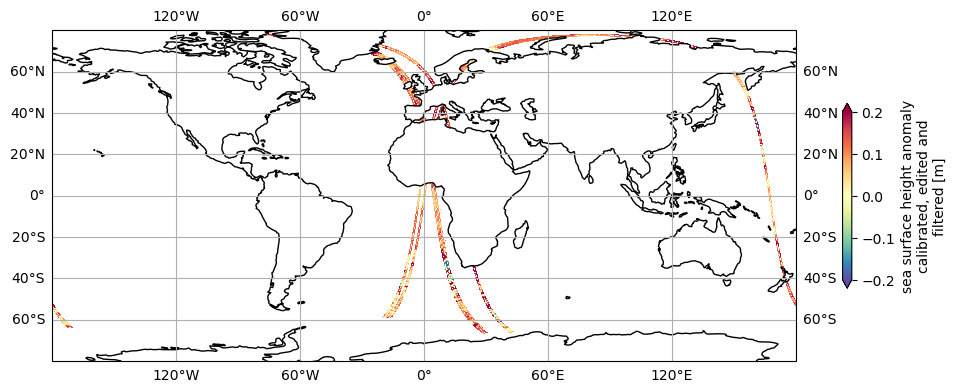

In [23]:
plot_datasets(downloaded_files, 'ssha_filtered', extent=[-180, 180, -80, 80])

## Subset data

In [26]:
subset_filenames = subset_files(downloaded_files, variables, lon_range, lat_range, output_dir)

Subset dataset: downloads/SWOT_L3_LR_SSH_Expert_019_001_20240730T190512_20240730T195638_v2.0.1.nc
Store subset: subset_SWOT_L3_LR_SSH_Expert_019_001_20240730T190512_20240730T195638_v2.0.1.nc
Subset dataset: downloads/SWOT_L3_LR_SSH_Expert_019_002_20240730T195639_20240730T204805_v2.0.1.nc
Dataset downloads/SWOT_L3_LR_SSH_Expert_019_002_20240730T195639_20240730T204805_v2.0.1.nc not matching geographical area.
Subset dataset: downloads/SWOT_L3_LR_SSH_Expert_019_029_20240731T190543_20240731T195709_v2.0.1.nc
Store subset: subset_SWOT_L3_LR_SSH_Expert_019_029_20240731T190543_20240731T195709_v2.0.1.nc
Subset dataset: downloads/SWOT_L3_LR_SSH_Expert_019_070_20240802T061503_20240802T070629_v2.0.1.nc
Store subset: subset_SWOT_L3_LR_SSH_Expert_019_070_20240802T061503_20240802T070629_v2.0.1.nc
Subset dataset: downloads/SWOT_L3_LR_SSH_Expert_019_098_20240803T061534_20240803T070700_v2.0.1.nc
Store subset: subset_SWOT_L3_LR_SSH_Expert_019_098_20240803T061534_20240803T070700_v2.0.1.nc
Subset dataset: 

In [27]:
subset_filenames

['downloads/subset_SWOT_L3_LR_SSH_Expert_019_001_20240730T190512_20240730T195638_v2.0.1.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Expert_019_029_20240731T190543_20240731T195709_v2.0.1.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Expert_019_070_20240802T061503_20240802T070629_v2.0.1.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Expert_019_098_20240803T061534_20240803T070700_v2.0.1.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Expert_019_236_20240808T043516_20240808T052642_v2.0.1.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Expert_019_376_20240813T043752_20240813T052918_v2.0.1.nc']

### Plot subsets

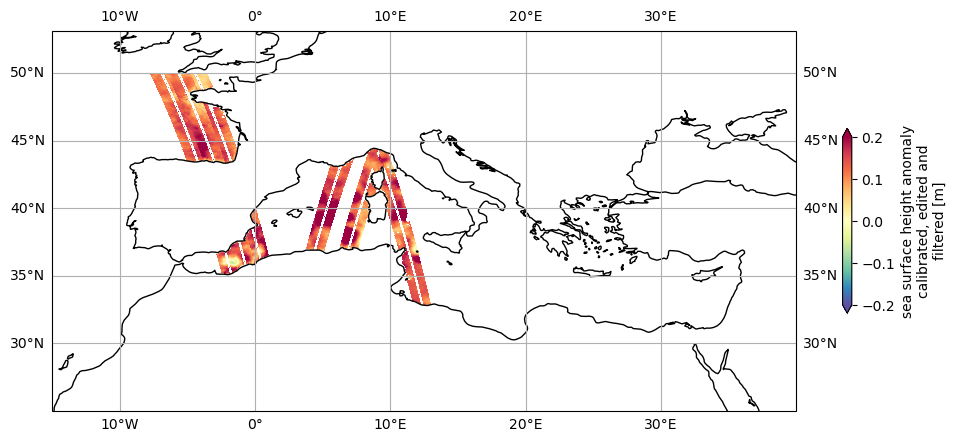

In [29]:
plot_datasets(subset_filenames, 'ssha_filtered', extent=localbox)